In [ ]:
# This notebook creates a sped-up dataset [0] and analyses the pitch differences between original and speed-modified audio files

# Part 1: Data Preparation (in[0] - in[3])
# - Uses ffmpeg-python for audio processing
# - Takes a dataset of WAV files and creates speed-modified versions using ffmpeg
# - Speed factor is set to 2x, maintaining the original audio pitch
# - Processes files in parallel with progress tracking

# Part 2: Visualization (in[4])
# - Implements spectrogram analysis to visualize frequency content over time
# - Creates comparison plots between original and speed-modified audio
# - Uses scipy's spectrogram function for frequency analysis
# - Displays results in dB scale with time-frequency heat maps

# Part 3: Pitch Analysis (in[5])
# - Uses librosa's pYIN algorithm for pitch tracking
# - Implements interactive file selection for individual file analysis
# - Calculates pitch differences between original and modified files
# - Focuses on musical range C2 to C7 for analysis

# Part 4: Statistical Analysis (in[6] - in[7])
# - Performs batch analysis of pitch shifts across entire dataset
# - Calculates key statistics (mean, median, std dev, IQR)
# - Tests for normality using Shapiro-Wilk test
# - Conducts one-sample t-test to verify pitch shift significance
# - Visualizes results using multiple plot types (histogram, boxplot, violin plot)

In [10]:
import os
import ffmpeg
import subprocess
from tqdm import tqdm

DATASET = "pb2007"
SPEED_FACTOR = 2

current_path = os.getcwd()

path_to_repo ="external/raw_datasets/"
path_to_data = os.path.join(current_path,path_to_repo, DATASET)
print(path_to_data)
output_directory = os.path.join(path_to_repo, f"{DATASET}_speedx{SPEED_FACTOR}","_wav16")

# Create the output directory if it does not exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Get all wav files in the specified subdirectory
wav_files = [f for f in os.listdir(os.path.join(path_to_data, "_wav16")) if f.endswith(".wav")]            

# Wrap file processing with tqdm to show progress bar
for file in tqdm(wav_files, desc="Processing files") :
    if file.endswith(".wav"):
        input_path = os.path.join(path_to_data, "_wav16",file)
        output_path = os.path.join(output_directory,file)
        cmd = [
            'ffmpeg', '-i', input_path,
            '-filter:a', f"atempo={SPEED_FACTOR}",
            output_path
        ]
        # Execute the ffmpeg command
        try:
            subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            # stdout and stderr are piped to suppress ffmpeg output, keeping the progress bar clean
        except subprocess.CalledProcessError as e:
            print(f"Error processing {file}: {e}")

/mnt/c/Users/vpaul/Documents/Inner_Speech/agent/external/raw_datasets/pb2007


Processing files:   0%|          | 0/1109 [00:00<?, ?it/s]

Processing files: 100%|██████████| 1109/1109 [01:04<00:00, 17.25it/s]


In [ ]:
# Pitch (spectrogram) comparison

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import os

def load_wav (file_path):
    """
    Load a WAV file.
    Args :
    - file_path : Path to the .wav file
    
    Returns : 
    - sample_rate : sample rate of the WAV file
    - data: Data of the WAV file
    """
    sample_rate, data = wavfile.read(file_path)
    return sample_rate, data

def plot_spectrogram(sample_rate, data, title):
    """
    Plot spectrogram of the WAV data with corresponding title
    """
    f, t, Sxx = spectrogram(data,sample_rate)
    plt.pcolormesh(t, f, 10*np.log10(Sxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.colorbar(label = 'Intensity[dB]')
    plt.show()

def analyze_datasets(dataset_path, speed_up_dataset_path):
    """
    Analyze and compare the datasets spectrums
    """
    # Assuming the files in both directories have the same names which is true for pb2007

    for file_name in os.listdir(dataset_path):
        original_path = os.path.join(dataset_path,file_name)
        speed_up_path = os.path.join(speed_up_dataset_path,file_name)

        #Load the original and speed-up WAV files
        sample_rate, wav_original = load_wav(original_path)
        sample_rate_speed_up, wav_speed_up = load_wav(speed_up_path)

        #Plot spectrogram for the original and speed up file
        plot_spectrogram(sample_rate,wav_original, f'Original - {file_name}')
        plot_spectrogram(sample_rate_speed_up, wav_speed_up, f'Speed up - {file_name}')

# Define your dataset directories
original_dataset_path = './datasets/pb2007/wav'
sped_up_dataset_path = './datasets/pb2007_speedx2/wav'

# Analyze the datasets
analyze_datasets(original_dataset_path, sped_up_dataset_path)


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import ipywidgets as ipw
from IPython.display import display

def pitch_shift_analysis(original_file, sped_up_file):
    """
    Analyze the pitch shift between an original and speed up file
    Returns : 
    - Pitch shift value in Hz
    """

    y_original, sr_original = librosa.load(original_file)
    y_sped_up, sr_sped_up = librosa.load(sped_up_file)

    # Extract pitches
    pitches_original, _ = librosa.pyin(y_original, fmin = librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')) # C means Do, for Do2 to Do7
    pitches_sped_up, _ = librosa.pyin(y_sped_up, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

    # Calculate average pitch for original and sped up
    avg_pitch_original = np.nanmean(pitches_original)
    avg_pitch_spedup = np.nanmean(pitches_sped_up)

    # Calculate pitch shift

    pitch_shift = avg_pitch_original - avg_pitch_spedup

    return pitch_shift

def interactive_file_selection(original_dataset_path, sped_up_dataset_path):
    """
    Creates a widget to select file and calculate pitch shift
    """
    files = os.listdir(original_dataset_path)
    file_selector = ipw.Select(option=files)
    out = ipw.Output()

    def on_file_selected(change):
        out.clear_output()
        with out : 
            selected_file = change['new']
            original_file_path = os.path.join(original_dataset_path, selected_file)
            sped_up_file_path = os.path.join(sped_up_dataset_path, selected_file)
            pitch_shift = pitch_shift_analysis(original_file_path, sped_up_file_path)
            print(f"Pitch Shift for {selected_file}: {pitch_shift} Hz")

            #Load the original and speed-up WAV files
            # sample_rate, wav_original = load_wav(original_file_path)
            # sample_rate_speed_up, wav_speed_up = load_wav(sped_up_file_path)

            # #Plot spectrogram for the original and speed up file
            # plot_spectrogram(sample_rate,wav_original, f'Original - {selected_file}')
            # plot_spectrogram(sample_rate_speed_up, wav_speed_up, f'Speed up - {selected_file}')

    file_selector.observe(on_file_selected, names='value')

# Assuming your dataset directories are defined
original_dataset_path = './datasets/pb2007/wav'
sped_up_dataset_path = './datasets/pb2007_speedx2/wav'

interactive_file_selection(original_dataset_path, sped_up_dataset_path)
    

Select(options=(), value=None)

Output()

/tmp/ipykernel_1263537/34421133.py:39: RuntimeWarning: Mean of empty slice
  avg_pitch_speedx2 = np.nanmean(voiced_pitches_speedx2)
/tmp/ipykernel_1263537/34421133.py:38: RuntimeWarning: Mean of empty slice
  avg_pitch_original = np.nanmean(voiced_pitches_original)


Min pitch is 95.58301872464601 and max pitch is 187.1258807529741


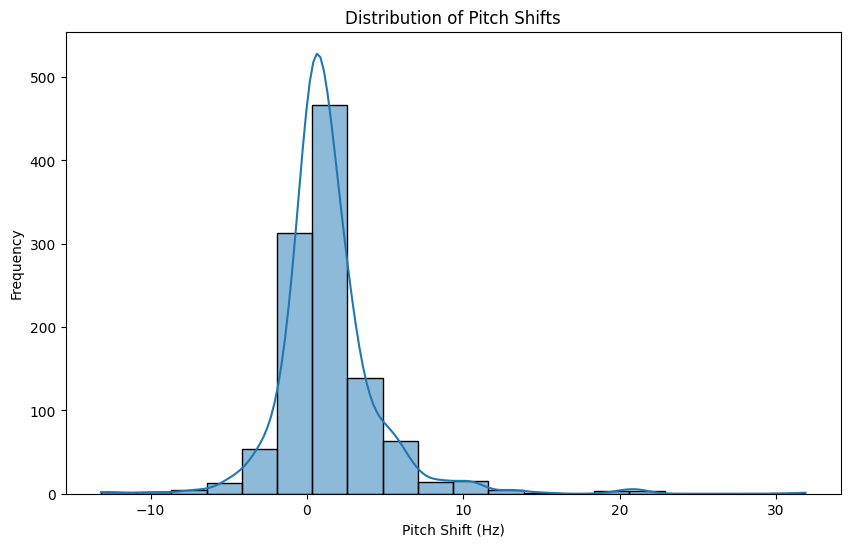

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

def calculate_pitch_shifts(dataset_path_original, dataset_path_speedx2):
    """
    Calculates the pitch shifts between original and speed-doubled audio files.

    Args:
        dataset_path_original (str): Path to the directory of the original audio files.
        dataset_path_speedx2 (str): Path to the directory of the speed-doubled audio files.

    Returns:
        A list of pitch shift values in Hz.
    """
    pitch_shifts = []
    file_names = os.listdir(dataset_path_original)
    max_pitch = 0
    min_pitch = 100000
    for file_name in file_names:
        original_file_path = os.path.join(dataset_path_original, file_name)
        speedx2_file_path = os.path.join(dataset_path_speedx2, file_name)

        # Load audio files
        y_original, sr_original = librosa.load(original_file_path)
        y_speedx2, sr_speedx2 = librosa.load(speedx2_file_path)

        # Pitch tracking using pYIN
        pitches_original, voiced_flag_original, voiced_probs_original = librosa.pyin(y_original, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        pitches_speedx2, voiced_flag_speedx2, voiced_probs_speedx2 = librosa.pyin(y_speedx2, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

        # Filter out unvoiced segments and calculate average pitch for voiced segments
        voiced_pitches_original = pitches_original[voiced_flag_original]
        voiced_pitches_speedx2 = pitches_speedx2[voiced_flag_speedx2]
        
        avg_pitch_original = np.nanmean(voiced_pitches_original)
        avg_pitch_speedx2 = np.nanmean(voiced_pitches_speedx2)
        if avg_pitch_original < min_pitch :
            min_pitch = avg_pitch_original
        elif avg_pitch_original > max_pitch : 
            max_pitch = avg_pitch_original
        # Calculate and store average pitch shift
        pitch_shift = avg_pitch_speedx2 - avg_pitch_original
        pitch_shifts.append(pitch_shift)
    print(f"Min pitch is {min_pitch} and max pitch is {max_pitch}")
    return pitch_shifts

def plot_pitch_shift_distribution(pitch_shifts):
    """
    Plots the distribution of pitch shifts.

    Args:
        pitch_shifts (list): List of pitch shift values in Hz.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(pitch_shifts, kde=True, bins=20)
    plt.title('Distribution of Pitch Shifts')
    plt.xlabel('Pitch Shift (Hz)')
    plt.ylabel('Frequency')
    plt.show()

# Example usage
dataset_path_original = './datasets/pb2007/wav'  # Update this path
dataset_path_speedx2 = './datasets/pb2007_speedx2/wav'  # Update this path
pitch_shifts = calculate_pitch_shifts(dataset_path_original, dataset_path_speedx2)
plot_pitch_shift_distribution(pitch_shifts)



/tmp/ipykernel_1263537/1432002841.py:38: RuntimeWarning: Mean of empty slice
  avg_pitch_speedx2 = np.nanmean(voiced_pitches_speedx2)
/tmp/ipykernel_1263537/1432002841.py:37: RuntimeWarning: Mean of empty slice
  avg_pitch_original = np.nanmean(voiced_pitches_original)


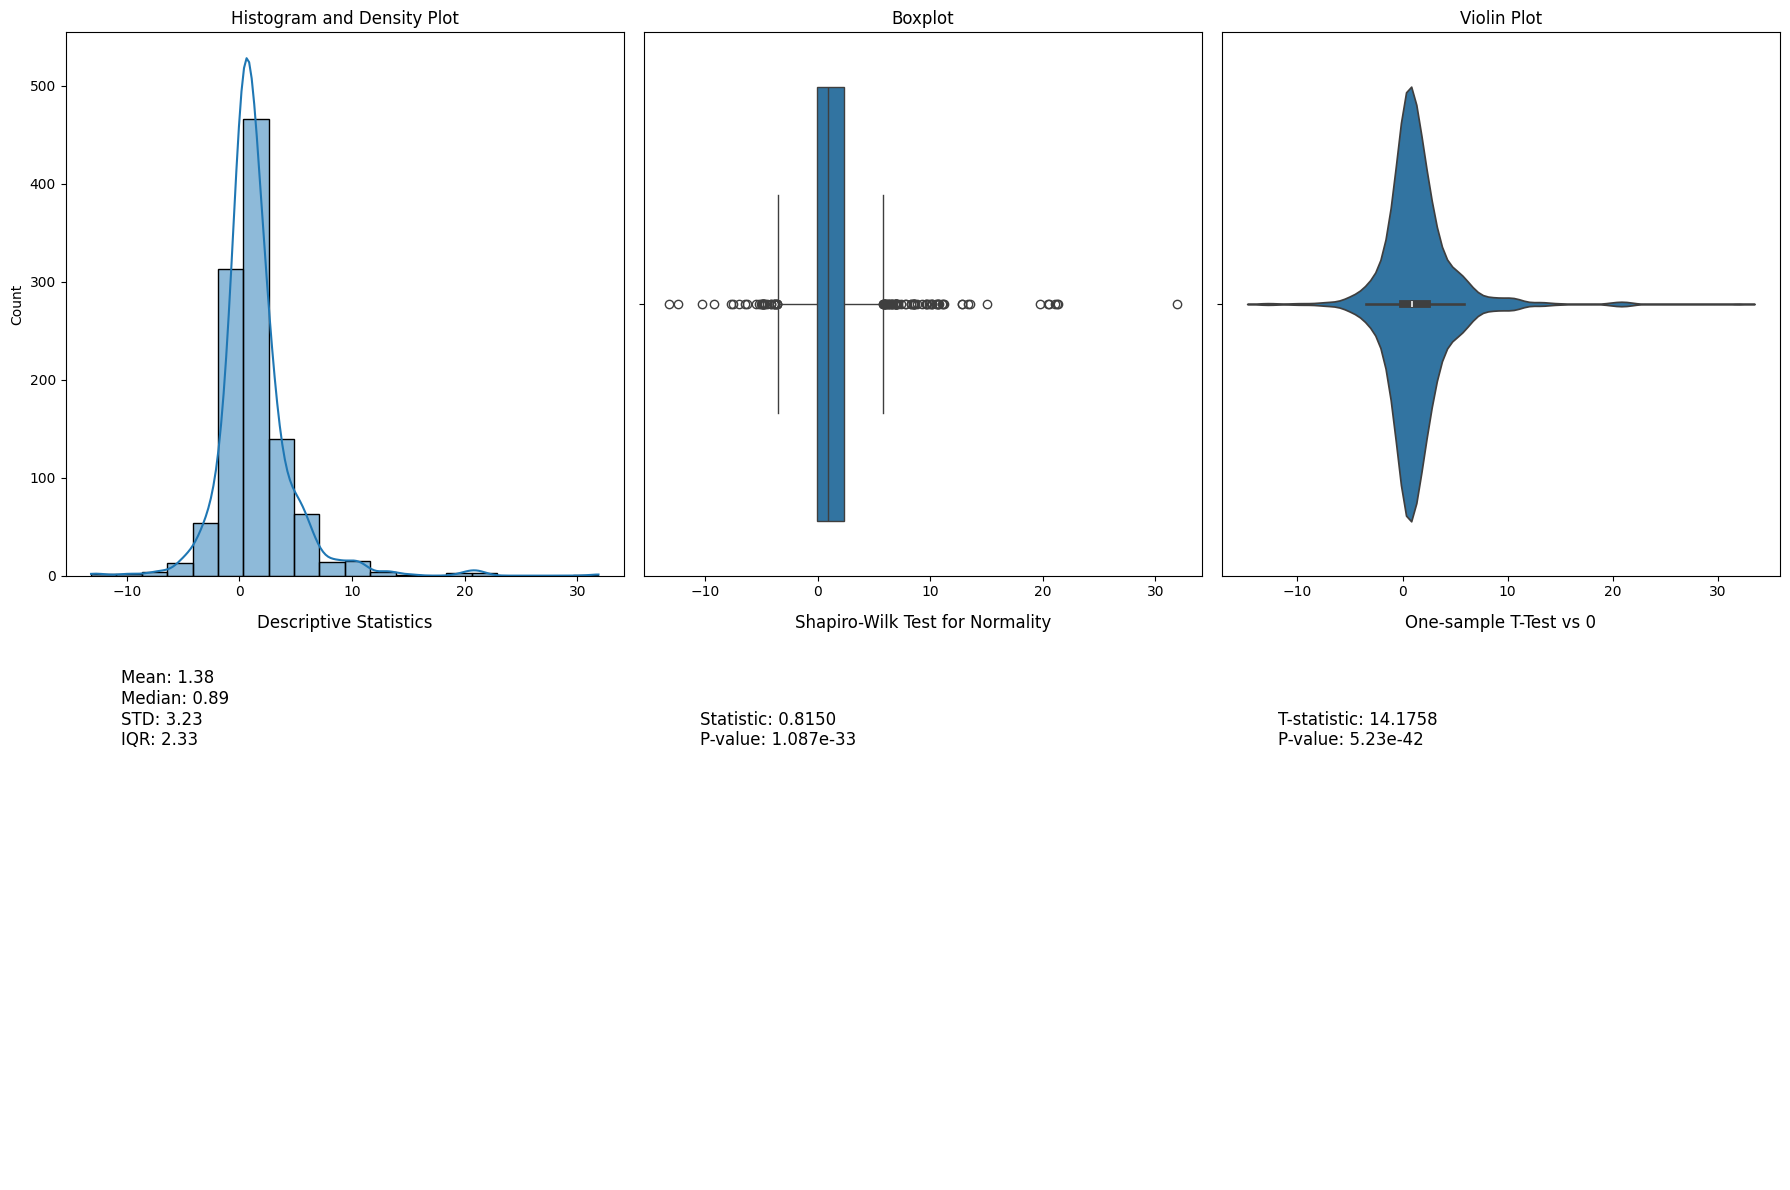

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import scipy.stats as stats

def extensive_analysis(pitch_shifts):
    pitch_shifts = [shift for shift in pitch_shifts if not np.isnan(shift)]
    plt.figure(figsize=(18, 12))

    # Histogram and density plot
    plt.subplot(2, 3, 1)
    sns.histplot(pitch_shifts, kde=True, bins=20)
    plt.title('Histogram and Density Plot')

    # Boxplot
    plt.subplot(2, 3, 2)
    sns.boxplot(x=pitch_shifts)
    plt.title('Boxplot')

    # Violin Plot
    plt.subplot(2, 3, 3)
    sns.violinplot(x=pitch_shifts)
    plt.title('Violin Plot')

    # Descriptive Statistics
    mean_val = np.mean(pitch_shifts)
    median_val = np.median(pitch_shifts)
    std_dev = np.std(pitch_shifts)
    iqr = stats.iqr(pitch_shifts)

    plt.subplot(2, 3, 4)
    plt.text(0.1, 0.8, f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nSTD: {std_dev:.2f}\nIQR: {iqr:.2f}', fontsize=12)
    plt.axis('off')
    plt.title('Descriptive Statistics')

    # Shapiro-Wilk Test for Normality
    stat, p_value = stats.shapiro(pitch_shifts)
    plt.subplot(2, 3, 5)
    plt.text(0.1, 0.8, f'Statistic: {stat:.4f}\nP-value: {p_value:.4g}', fontsize=12)
    plt.axis('off')
    plt.title('Shapiro-Wilk Test for Normality')


    # One-sample t-test against 0
    t_stat, p_val_ttest = stats.ttest_1samp(pitch_shifts, 0)
    plt.subplot(2, 3, 6)
    plt.text(0.1, 0.8, f'T-statistic: {t_stat:.4f}\nP-value: {p_val_ttest:.4g}', fontsize=12)
    plt.axis('off')
    plt.title('One-sample T-Test vs 0')

    plt.tight_layout()
    plt.show()

# Example usage
dataset_path_original = './datasets/pb2007/wav'  # Update this path
dataset_path_speedx2 = './datasets/pb2007_speedx2/wav'  # Update this path
pitch_shifts = calculate_pitch_shifts(dataset_path_original, dataset_path_speedx2)
extensive_analysis(pitch_shifts)